>> 1. 이미지 불러오고 확인하기

마스크 착용여부를 확인하는 모델을 만들어봅시다

Kaggle.com 에는 딥러닝 및 머신러닝 모델링에 활용할 수 있는 다양한 데이터셋이 있습니다. 

마스크 데이터셋을 선택하여 다운로드 해봅시다

https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset

kaggle 다운로드를 위해서는 회원가입이 필요합니다. (무료)

이미지를 다운로드 한 후에 구글 드라이브에 업로드 합시다


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
data_dir = '/content/drive/MyDrive/Tensorflow AI/New Masks Dataset'

텐서플로우에는 이미지 폴더를 손쉽게 불러올 수 있는 image_dataset_from_directory() 함수를 제공합니다.

위 함수를 통해서 불러오기 위해서는 아래와 같이 클래스별로 폴더가 나뉘어 있어야 합니다. 

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.
```

참고링크
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

이미지 사이즈를 150 x 150이 되도록 하여 불러봅시다

In [4]:
# 구글 드라이브에서 데이터 불러오기
img_height = 150
img_width = 150
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Train',    
  batch_size=32,
  image_size=(img_height, img_width))

Found 600 files belonging to 2 classes.


폴더명이 자동으로 class명으로 저장됩니다

In [5]:
train_ds.class_names

['Mask', 'Non Mask']

이렇게 불러온 데이터셋은 반복문을 통해 특정 이미지를 확인할 수 있습니다. 

take()를 사용하면 batch 단위로 이미지를 읽어 옵니다. 

폴더명은 label로 자동으로 지정됩니다. 

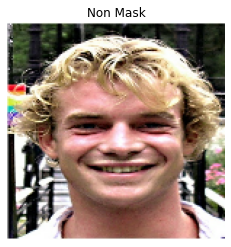

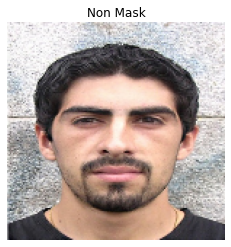

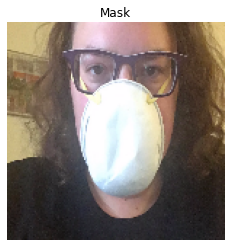

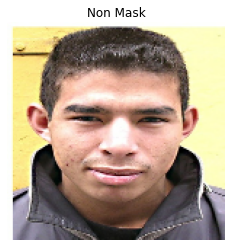

In [6]:
# 데이터의 이미지들을 살펴봅니다. 
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
  for i in range(4):
    plt.figure()
    plt.imshow(images[i].numpy().astype('int'))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
    plt.show()

take(batch 개수) 입니다. 1을 입력하면 batch_size 만큼의 이미지를 한번에 가져옵니다.  3을 입력하면 3개의 batch를 가져옵니다

In [7]:
imgs = []
for img, lable in train_ds.take(3):
  print(img.shape)
  print(lable.shape)

(32, 150, 150, 3)
(32,)
(32, 150, 150, 3)
(32,)
(32, 150, 150, 3)
(32,)


validation과 test 데이터셋도 가져옵니다

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Validation',    
  image_size=(img_height, img_width))

Found 306 files belonging to 2 classes.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Test',    
  image_size=(img_height, img_width))

Found 100 files belonging to 2 classes.


>> 2. 모델 만들기

2개이 클래스를 분류하는 CNN 모델을 만들어 봅시다. 

Rescaling()을 활용하여 0 ~ 255인 이미지 숫자값을 1/255를 곱해서 0~1사이의 값으로
정규화를 해주겠습니다. 

one hot encoding을 하지 않고, loss function을 sparse categorical entropy를 사용하여 분류되도록 하겠습니다

In [13]:
num_classes = 2
epochs = 5

from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32,(3,3),padding='SAME',activation='relu'))  # kernel size가 같은 경우는 한개로 써도 됨 (3,3) --> 3
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,(3,3),padding='SAME',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,(3,3),padding='SAME',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,activation='softmax'))
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['acc'])
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 37, 37, 128)      

테스트셋에 대해 평가해봅시다

In [14]:
# 테스트셋 정확도 평가

test_loss , test_acc = model.evaluate(test_ds)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 14s 51ms/step - loss: 0.2095 - acc: 0.9100
test acc :0.9100000262260437 test loss:0.20953860878944397


In [15]:
# 모델 저장하기
model.save(data_dir+'mask.h5')

판별이 잘못된 이미지를 살펴봅니다

In [16]:
pred_y = model.predict(test_ds)

In [17]:
pred_y.shape

(100, 2)

In [18]:
pred_y[0]

array([0.9898722 , 0.01012779], dtype=float32)

Batch Dataset의 경우 take를 통해 불러올 때마다 다른 이미지가 나오게 됩니다

[1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1]
[0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1]


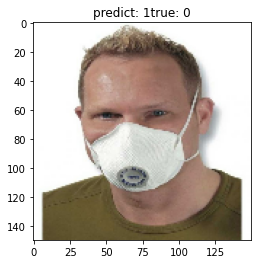

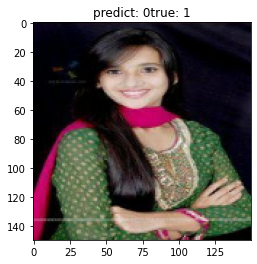

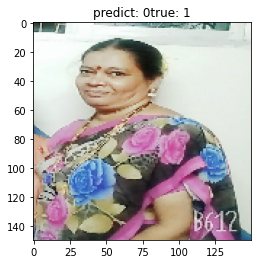

In [27]:
import numpy as np

for images, labels in train_ds.take(1):
  pred_y = model.predict(images)
  pred_y = np.argmax(pred_y, axis = 1)
  for i in range(len(images)):
    if pred_y[i] != labels[i]:
      plt.figure()
      plt.imshow(images[i].numpy().astype('int'))
      plt.title('predict: '+ str(pred_y[i]) + 'true: '+ str(labels[i].numpy()))



In [26]:
train_ds.class_names

['Mask', 'Non Mask']